In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.stats import t
from scipy import stats

In [2]:
#ich habe als unabhängige Variable folgende
# - Temperatur
# - Preis
# - Uhrzeit - mit Sin und Cos ausgedrückt um das zyklische Verhalten zu bekommen. 
#   Ich habe weiters auch noch sin(2Pi*x/12) und mit cos hinzugefügt um Vor- und Nachmittagsspitzen darzustelle. Ich bin mir ned sicher ob dies nötig/richtig ist
# - Lag: ich habe eine Abhängigkeit von der vorherigen Last hinzugefügt, ich weiß wieder nicht ob das gewollt ist, es verbessert den R² aber deutlich. 

df_price = pd.read_csv("preise2023.csv")
df_load = pd.read_csv("load2023.csv")
hours = pd.Series(range(8760))    #csv eingelesen und hours erstellt
df_temp = pd.read_csv("MessstationenStundendaten.csv")
timeseries = list(range(24))*365
clock = pd.Series(timeseries)
df_sinclock = np.sin(2 * np.pi * clock / 24)
df_cosclock = np.cos(2 * np.pi * clock / 24)
df_sinclock_half = np.sin(2 * np.pi * clock / 12)
df_cosclock_half = np.cos(2 * np.pi * clock / 12)

df_temp.rename(columns={'tl': 'Temp'}, inplace=True)
df_price.rename(columns={'AT': 'Price'}, inplace=True)
df_load.rename(columns={'load': 'Load'}, inplace=True)  #csv Spaltennamen renamed
df_combined = pd.concat([hours, clock, df_price['Price'], df_load['Load'], df_temp['Temp']], axis=1) #daten in ein dataframegepackt 
df_combined.rename(columns={df_combined.columns[0]: 'hours'}, inplace=True) #hours spalte in hours umbenannt
df_combined.rename(columns={df_combined.columns[1]: 'clock'}, inplace=True) #hours spalte in clock umbenannt
df_combined['Load_lagged'] = df_combined['Load'].shift(1) #Setzt meinen Wert in Zusammenhang mit dem t-1 Wert
#df_combined['Sin_clock'] = df_sinclock                  #Uhrzeit durch Sin ausdrücken ist nicht signifikant
df_combined['Cos_clock'] = df_cosclock                  #Uhrzeit durch Cos ausdrücken
df_combined['Sin_clock_half'] = df_sinclock_half               #Uhrzeit durch Sin ausdrücken
df_combined['Cos_clock_half'] = df_cosclock_half                  #Uhrzeit durch Cos ausdrücken
df_combined = df_combined[df_combined['Price'] > 0]     #Preise unter 0 weggecuttet -> nicht wegcutten, sondern 0 setzen
df_combined = df_combined.fillna(df_combined.mean())    #Tauscht Nan-Werte mit Spaltenmittelwert aus (Temp. hatte Nan-Werte) -> könnte man noch verbessern wenn man z.B. mittelwert aus 7 & 9 Uhr für fehlenden wert bei 8 Uhr verwendet.


# Model 1

In [4]:
X = df_combined[['Load']]  # Unabhängige Variablen definieren
X = sm.add_constant(X)  # Konstanten-Term hinzufügen (Intercept)

y = df_combined['Price']  # Zielvariable

model = sm.OLS(y, X).fit()  # OLS-Regression (Ordinary Least Squares)

# Ergebnisse ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     3701.
Date:                Fri, 04 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:33:12   Log-Likelihood:                -23049.
No. Observations:                8623   AIC:                         4.610e+04
Df Residuals:                    8621   BIC:                         4.612e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3351      0.197     -6.794      0.0

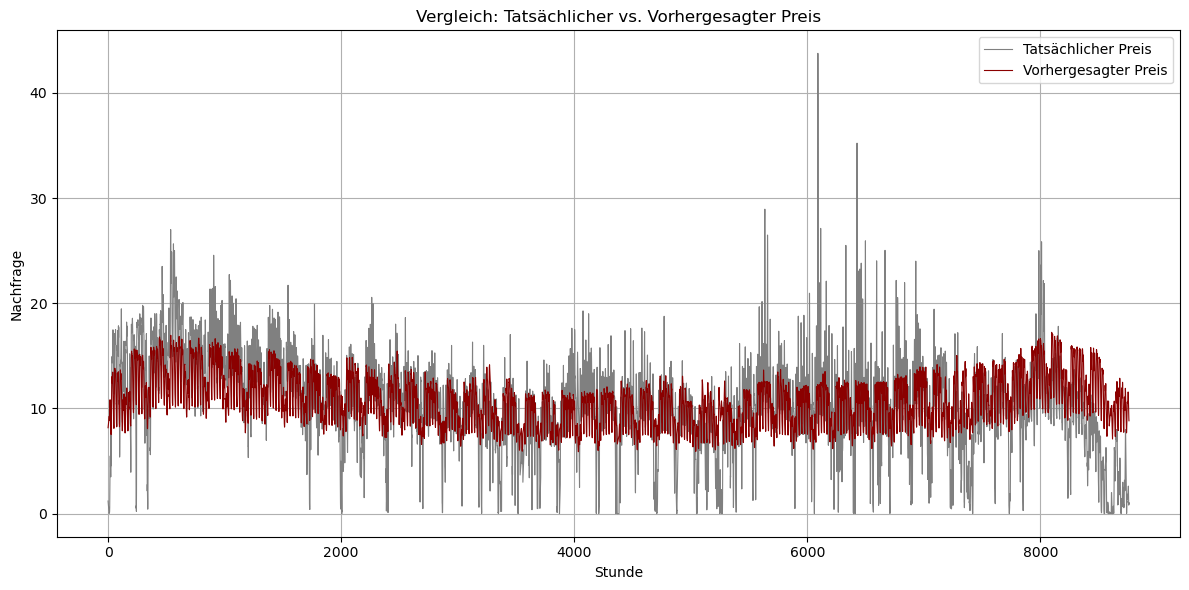

In [12]:
beta0 = -1.3351
beta1 = 0.0018
df_combined['y_t'] = beta0+df_combined['Load']*beta1

plt.figure(figsize=(12, 6))
plt.plot(df_combined['hours'], df_combined['Price'], label='Tatsächlicher Preis', color='grey', linewidth='0.8')
plt.plot(df_combined['hours'], df_combined['y_t'], label='Vorhergesagter Preis', color='darkred',linewidth='0.8')

plt.title('Vergleich: Tatsächlicher vs. Vorhergesagter Preis')
plt.xlabel('Stunde')
plt.ylabel('Nachfrage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()